In [1]:
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import MDAnalysis as mda
from tqdm import tqdm
from numpy import linalg as LA
from scipy.signal import lfilter

In [2]:
runs = sorted(glob.glob("../../traj_save/*//*.pdb"))

In [3]:
def dist_pbc(a, b, box):
    """
    calculate distance between two points
    in PBC box
    """
    assert len(a) == len(b)
    box = box[:len(a)]
    a = a % box
    b = b % box
    dist_vec = np.abs(a - b)
    dist_vec = np.abs(dist_vec - box * (dist_vec > box/2))
    return LA.norm(dist_vec)
    print(dist_vec)

In [13]:
df = []

for run in runs:
    pdb_file = run
    dcd_file = run.replace("pdb", "dcd")

    run_base = os.path.basename(run)[:-4]
    if run.split('/')[-2] == 'Nsp10_Nsp16': 
        run_base += '_000'
#     print(run_base)

    mda_traj = mda.Universe(pdb_file, dcd_file)

    nsp16 = mda_traj.segments[0].atoms
    nsp10 = mda_traj.select_atoms("segid B")
    no_sol = mda_traj.select_atoms("protein")
    dist_list = []
    for ts in tqdm(mda_traj.trajectory):
        dist = dist_pbc(
            nsp10.center_of_mass(), 
            nsp16.center_of_mass(), 
            ts.dimensions)
#         dist_list += [dist]
        
        df.append({'sys_name': run_base,
                    'frame': ts.frame,
    #                    'dist_vec': dist_vec,
                   'dist': dist})

100%|██████████| 4000/4000 [00:01<00:00, 2215.59it/s]


In [14]:
df = pd.DataFrame(df)
df.head()

,sys_name,frame,dist
0,comp_000,0,32.605477
1,comp_000,1,32.323373
2,comp_000,2,31.932924
3,comp_000,3,32.521470
4,comp_000,4,32.193099


In [15]:
df.to_pickle('dist_nsp10-16.pkl')

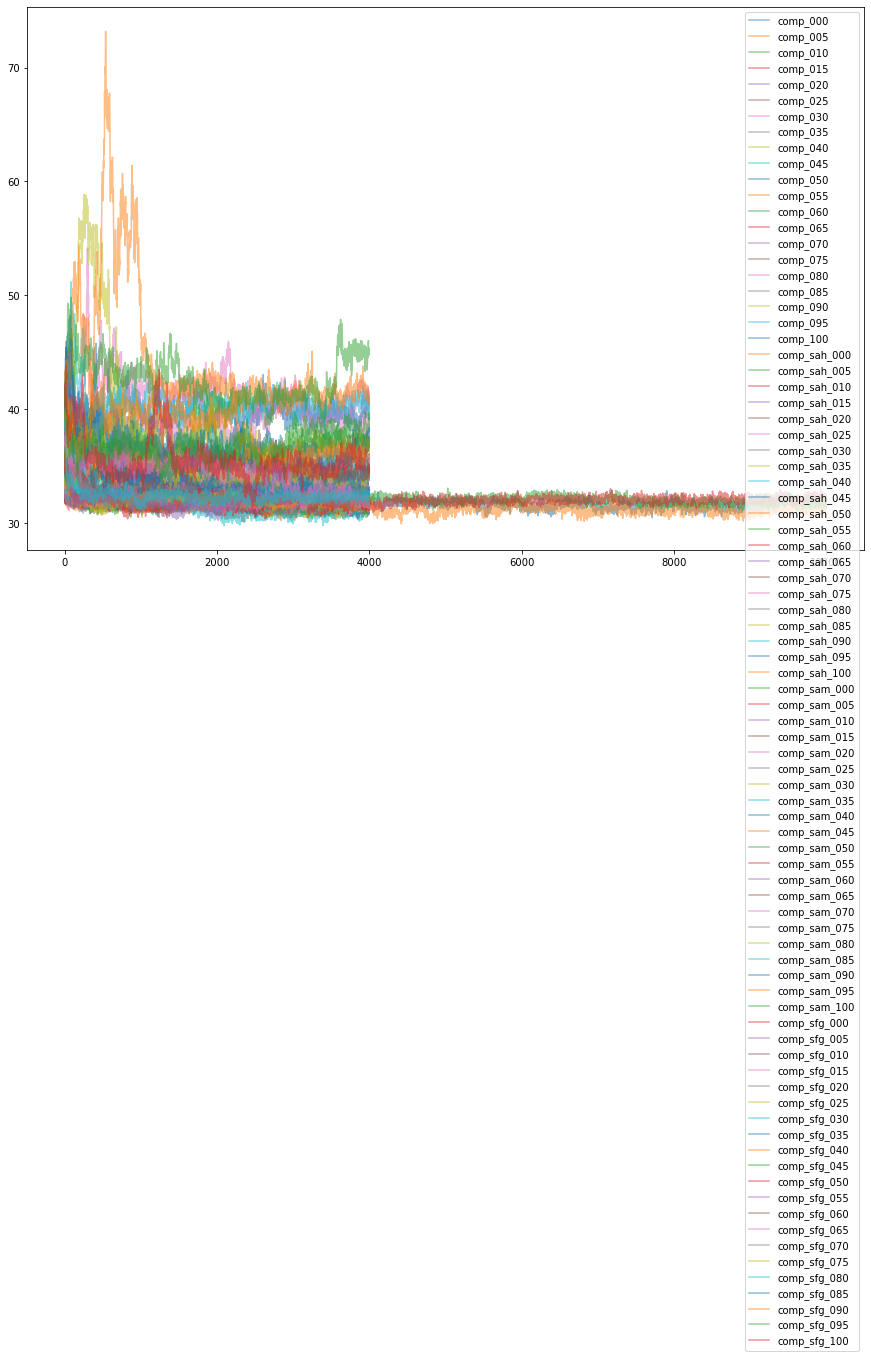

In [16]:
fig, axes = plt.subplots( figsize=(15,10)) 
n_traj = 0 

for sys_name in sorted(df.sys_name.unique()): 
    sub_df = df[df['sys_name'] == sys_name]
    axes.plot(sub_df['frame'], sub_df['dist'], label=sys_name, alpha=.5) 
plt.legend()
plt.savefig('dist.pdf')